# Playing Atari with Actor-Critic Method (AC) and Its Extentions (AC-replay, AC-replay(balanced))

###   (value-based) Q learning algorithm : Critic
###  (action-based) Policy Gradient :  Actor 

This notebook defines Critic and Actor class, and train AC agent on game LunarLanderV2.0 under openAI gym enviornment.




In [1]:
import gym
from gym import envs
from gym import wrappers

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import argparse
import logging
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from Network.CNN import CNN
from Network.deepnetsoftmax import Netsoftmax
from Network.deepnet import Net
from MemoryBuffer import ReplayMemory



# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [2]:
configC = {
    "inputs_dim": 8,
    "hidden_dim": 50,
    "outputs_dim": 1,     # one state value of given state
    "GAMMA": 0.99,
    "learning_rate": 0.00025,#0.01,
    "weight_decay": 0.0001,
    "betas": (0.001, 0.9)
    
    
}

configA = {
    "inputs_dim": 8,
    "hidden_dim": 50,
    "outputs_dim": 4,    # action space probability
    "GAMMA": 0.99,
    "learning_rate": 0.00025, #0.001/2,
    "weight_decay": 0.0001,
    "betas": (0.001, 0.9)
    
}

In [56]:
class Critic(object):
    """Same as Q learning. 
       Estimate state value, not state action value. 
       Compute the loss between v and v_next
    
       TD_error = (r+gamma*V_next) - V_eval
    
        In AC, Critic leave the job of picking action to Actor.
        Only make comments, i.e. compute vt in -log(prob)*vt.
    """
    
    def __init__(self, observation_space, action_space, lr_scheduler=None): 
    # 搭建好 Critic 神经网络
        self.q = Net(observation_space.shape[0], \
                        configC["outputs_dim"], configC["hidden_dim"])
        
        self.optimizer = optim.Adam(self.q.parameters(), lr=configC["learning_rate"], \
                                        betas=configC["betas"], \
                                        weight_decay=configC["weight_decay"] if configC["weight_decay"] else None)
        self.loss =  torch.nn.MSELoss()  
        self._loss_=[]
        
        
    def learn(self, s, r, s_):  
    # Critic 的更新很简单, 就是像 Q learning 那样更新现实和估计的误差 (TD error) 
    # 学习 状态的价值 (state value), 不是行为的价值 (action value),
    # 计算 TD_error = (r + v_) - v,
    # 用 TD_error 评判这一步的行为有没有带来比平时更好的结果,
    # 可以把它看做 Advantage 
    
        if len(s.shape)==1: s, s_, r = s_[np.newaxis, :], s_[np.newaxis, :], np.array([[r]]) 
        
        s, s_ = Variable(torch.from_numpy(np.asarray(s))).float(), \
                Variable(torch.from_numpy(np.asarray(s_)), volatile=True).float()      # shape=(N, 8)
           
        self.optimizer.zero_grad()
    
        state_values = self.q(s)    # v shape=(N, 1)
    
        next_state_values = self.q(s_)   # v_ shape=(N, 1)
        next_state_values.volatile = False
        
        # v_ex = gamma*v_ + r    shape=(N,1)
        expected_state_values = torch.cat([torch.add((next_state_values[i] * configC["GAMMA"]), \
                                   r[i][0]) for i in range(r.shape[0])],0).view(s.size()[0], 1)    
        # expected_state_values = torch.add((next_state_values * configC["GAMMA"]), r) 
        
        td_error = expected_state_values.sub(state_values)     # TD_error = r+gamma*v_ - V   shape=(N, 1)
        loss = torch.mean((expected_state_values.sub(state_values))**2)   # mean squared TD_error    shape=(1, )
        
        print "Critic: TD error"
        print td_error
        
        # Update model
        loss.backward()
        self.optimizer.step()
    
        # Append loss to array
        self._loss_.append(torch.mean(td_error).data.numpy()[0])
        
        td_error = td_error.data.numpy()    
        return td_error    
        
        
    def plot():
        return
           

In [57]:
 class Actor(object):
    """Policy Gradient Learning algorithm.
    
       Action based method: network estimate the probability of each action P(a),
       loss is log probability * td_error, 
       P(a) reinforced by rewards from RL environment.
       
       update over every epoch (v.s.per step)
    """
    
    
    def __init__(self, observation_space, action_space, lr_scheduler=None):
        self.q = Netsoftmax(observation_space.shape[0], \
                        configA["outputs_dim"], configA["hidden_dim"])
       
        self.optimizer = optim.Adam(self.q.parameters(), lr=configA["learning_rate"], \
                                        betas=configA["betas"], \
                                        weight_decay=configA["weight_decay"] if configA["weight_decay"] else None)
        
        self.ep_obs=[]
        self.ep_as=[]
        self.ep_rs=[]
        self._loss_=[]

    
    def choose_action(self, observation):
    ## Choose a from s
    ## 这个行为不再是用 Q value 来选定的, 而是用概率来选定. 概率即预测概率
    ## 即使不用 epsilon-greedy, 也具有一定的随机性 
    ## Return the action picked  
        observation = Variable(torch.from_numpy(observation), \
                           volatile=True).float().view(1, configA["inputs_dim"])
        
        prob_weights = self.q(observation)  # train
        
        print "(pick)Actor: act prob"
        print prob_weights
        
        prob_weights = prob_weights.data.numpy()
        action = np.random.choice(range(prob_weights.shape[1]), p=prob_weights.ravel()) 
        #prob_a = prob_weights[0][action]
        
        return action 
    
  
    def learn(self, s, a, td):
    # Actor 想要最大化期望的 reward, 在 Actor Critic 算法中, 
    # 我们用 “比平时好多少” (TD error) 来当做 reward
    # s, a 用于产生 Gradient ascent 的方向,
    # td 来自 Critic, 用于告诉 Actor 这方向对不对.
        if len(s.shape)==1: 
            s, a = s[np.newaxis, :], np.array([[a]])    # (N, x)
          
        self.optimizer.zero_grad()
        
        acts_prob = self.q(Variable(torch.from_numpy(np.asarray(s))).float())    # (N, 4)
        
        print "(learn)Actor: act prob"
        print acts_prob
        
        # Compute Loss
        #log_prob = torch.log(acts_prob[0, a])  # 单个数据version
        #loss = -torch.mean(torch.mul(log_prob, td))  
        log_prob = torch.log(torch.cat([acts_prob[i,a[i][0]] for i in range(a.shape[0])],0)) # log 动作概率    (N, )         
        loss = -torch.mean(torch.cat([torch.mul(log_prob[i], float(td[i][0])) \
                                                for i in range(td.shape[0])],0))  # log 概率 * TD 方向    (1, )
                  
        # 因为我们想不断增加这个 exp_v (动作带来的额外价值),
        # 所以我们用过 minimize(-exp_v) 的方式达到
        # maximize(exp_v) 的目的
        print "Actor: log prob * vt"
        print -loss 
        
        # Optimize Model 
        loss.backward()
        self.optimizer.step()
        
        loss =  loss.data.numpy()[0] 
        self._loss_.append(-loss)
        return -loss
        
        
    def plot():
        return
        
        

In [58]:
def plot(x,d,la,lc):
    fig = plt.figure(figsize=(12,12))
    plt.clf()
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    
    ax1.plot(x)
    ax2.plot(d)
    ax3.plot(la)
    ax4.plot(lc)
    ax1.set_title('REWARD - Training LunarLander-v2')
    ax1.set_ylabel('Reward per Episode')
    ax2.set_ylabel('Durations per Episode')
    ax3.set_ylabel('Actor Loss per Episode')
    ax4.set_ylabel('Critic Loss(TDerror) per Episode')
    
    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
        

In [59]:
def start(GAME_NAME):
    print "make enviornment"
    env = gym.make(GAME_NAME)
    print "create actor, critic"
    actor = Actor(env.observation_space, env.action_space)
    critic = Critic(env.observation_space, env.action_space)
    reward_per_epi=[]
    durations_per_epi=[]
    l_A=[]
    l_C=[]
    MAX_EPISODE = 150
    RENDER = False
    MAX_EP_STEPS= 1000
    DISPLAY_REWARD_THRESHOLD=200
    
    
    print "begin.\n\n"
    for i_episode in range(MAX_EPISODE):
        s = env.reset()
        track_r = []    # 每回合的所有奖励
        critic._v_=[]
        actor._loss_=[]
        for t in count():
            if RENDER: env.render()

            a = actor.choose_action(s)

            s_, r, done, info = env.step(a)     

            if done: r = -20    # 回合结束的惩罚/ Penalty if die

            track_r.append(r)

            td_error = critic.learn(s, r, s_)  # Critic Learn 学习
            actor.learn(s, a, td_error)     # Actor Learn 学习

            s = s_
            
            print "... in episode (%d) step (%d)" % (i_episode+1,t)
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())
                
            #env.render()

            if done or t >= MAX_EP_STEPS:
                # 回合结束, 打印回合累积奖励

                ep_rs_sum = sum(track_r)/float(t)
                if 'running_reward' not in globals():
                    running_reward = ep_rs_sum
                else:
                    running_reward = running_reward * 0.95 + ep_rs_sum * 0.05
                if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True  # rendering
                reward_per_epi.append(running_reward)
                durations_per_epi.append(t)
                l_A.append(np.mean(actor._loss_))
                l_C.append(np.mean(critic._loss_))
                print("episode:", i_episode, "  reward:", running_reward)
                plot(reward_per_epi, durations_per_epi, l_A, l_C)

                break
            
    return reward_per_epi, durations_per_epi, l_A, l_C       

    

In [60]:
def r_percent(r, t):
    n=len(r)
    c=0.
    for i in r:
        if i>=t:
            c += 1
    return c/n
    


### Inception  

{'learning_rate': 0.00025, 'outputs_dim': 4, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}
{'learning_rate': 0.00025, 'outputs_dim': 1, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}


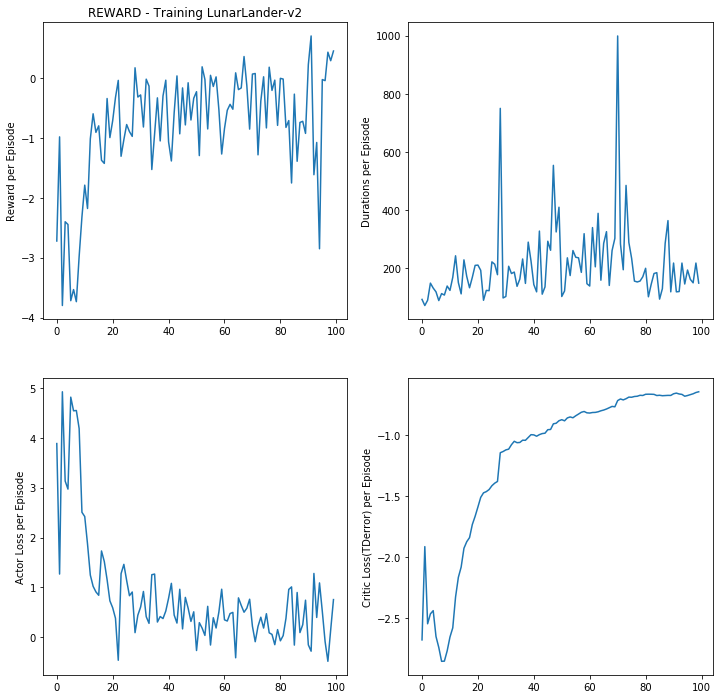

In [13]:
#r, d, l_A, l_C = start('LunarLander-v2')
plot(r, d, l_A, l_C)
print configA
print configC

In [35]:
print "episode, r > 0: %.01f%s" % (float(r_percent(r, 0)*100), "%")
print "episode, r > -1: %.01f%s" % (float(r_percent (r, -1)*100) , "%")
print "episode, r > -2: %.01f%s" % (float(r_percent (r, -2)*100) , "%")
print "Highest score: %.02f" % max(r)
print "Highest total score: %.01f" % max([x*y for x, y in zip(r, d)])

episode, r > 0: 16.0%
episode, r > -1: 72.0%
episode, r > -2: 89.0%
Highest score: 0.70
Highest total score: 126.5


configA: 
{'learning_rate': 0.00025, 'outputs_dim': 4, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}
configC: 
{'learning_rate': 0.00025, 'outputs_dim': 1, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}


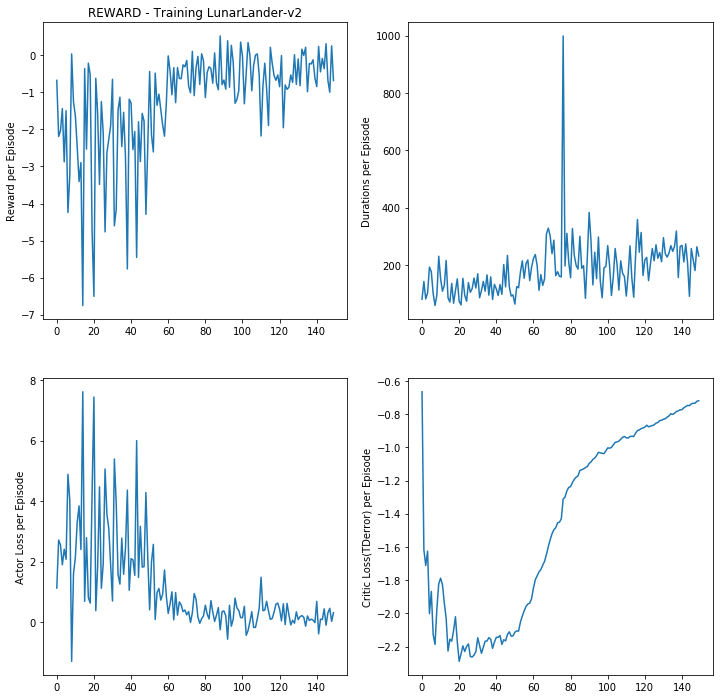

In [43]:
#r, d, l_A, l_C = start('LunarLander-v2')
plot(r, d, l_A, l_C)
print "configA: "
print configA
print "configC: "
print configC

In [42]:
print "episode, r > 0: %.01f%s" % (float(r_percent(r, 0)*100), "%")
print "episode, r > -1: %.01f%s" % (float(r_percent (r, -1)*100) , "%")
print "episode, r > -2: %.01f%s" % (float(r_percent (r, -2)*100) , "%")
print "Highest score: %.02f" % max(r)
print "Highest total score: %.01f" % max([x*y for x, y in zip(r, d)])

episode, r > 0: 12.7%
episode, r > -1: 58.7%
episode, r > -2: 78.7%
Highest score: 0.52
Highest total score: 80.7


### Inception - with experience replay  (AC-REPLAY)
*I add expereince replay in DQN method to AC method so that the agent learns from a batch of un-correlated samples (state, action and reward) from previous experiences *

*AC-replay provides: *
* *A batch of samples to train, compared with only one in AC  *
* *Network is able to be trained with un-correlated samples *

In [44]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

def start_r(GAME_NAME, BATCH_SIZE):
    print "make enviornment"
    env = gym.make(GAME_NAME)
    print "create actor, critic"
    actor = Actor(env.observation_space, env.action_space)
    critic = Critic(env.observation_space, env.action_space)
    reward_per_epi=[]
    durations_per_epi=[]
    l_A=[]
    l_C=[]
    
    MAX_EPISODE = 150
    RENDER = False
    MAX_EP_STEPS= 1000
    DISPLAY_REWARD_THRESHOLD=200
    BATCH_SIZE=BATCH_SIZE  # try 5
    MEMORY_CAPACITY=5000
    replay_memory = ReplayMemory(MEMORY_CAPACITY)
    
    print "begin.\n\n"
    for i_episode in range(MAX_EPISODE):
        s = env.reset()
        track_r = []    # 每回合的所有奖励
        critic._v_=[]
        actor._loss_=[]
        for t in count():
            if RENDER: env.render()

            a = actor.choose_action(s)

            s_, r, done, info = env.step(a)

            if done: r = -20    # 回合结束的惩罚/ Penalty if die

            track_r.append(r)
            
            ################## ################  
            replay_memory.save(s, a, r, s_)   # Save transition into memeory
            
            if len(replay_memory) > BATCH_SIZE:
                
                transitions = replay_memory.sample(BATCH_SIZE)   # Sample from memory for training
                batch = Transition(*zip(*transitions))
                
                s_b = np.asarray(batch.state)       
                s_b_n = np.asarray(batch.next_state)  
                a_b = np.asarray(batch.action).reshape(BATCH_SIZE, 1)
                r_b = np.asarray(batch.reward).reshape(BATCH_SIZE, 1) 
                
                td_error = critic.learn(s_b, r_b, s_b_n)    # Critic Learn  
                actor.learn(s_b, a_b, td_error)       # Actor Learn     
            ################## ################

            s = s_
            
            print "... in episode (%d) step (%d)" % (i_episode+1,t)
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())
            #env.render()

            if done or t >= MAX_EP_STEPS:
                # 回合结束, 打印回合累积奖励

                ep_rs_sum = sum(track_r)/float(t)
                if 'running_reward' not in globals():
                    running_reward = ep_rs_sum
                else:
                    running_reward = running_reward * 0.95 + ep_rs_sum * 0.05
                if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True  # rendering
                reward_per_epi.append(running_reward)
                durations_per_epi.append(t)
                l_A.append(np.mean(actor._loss_))
                l_C.append(np.mean(critic._loss_))
                print("episode:", i_episode, "  reward:", running_reward)
                plot(reward_per_epi, durations_per_epi, l_A, l_C)

                break
            
    return reward_per_epi, durations_per_epi, l_A, l_C       

    

configA: 
{'learning_rate': 0.00025, 'outputs_dim': 4, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}
configC: 
{'learning_rate': 0.00025, 'outputs_dim': 1, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}


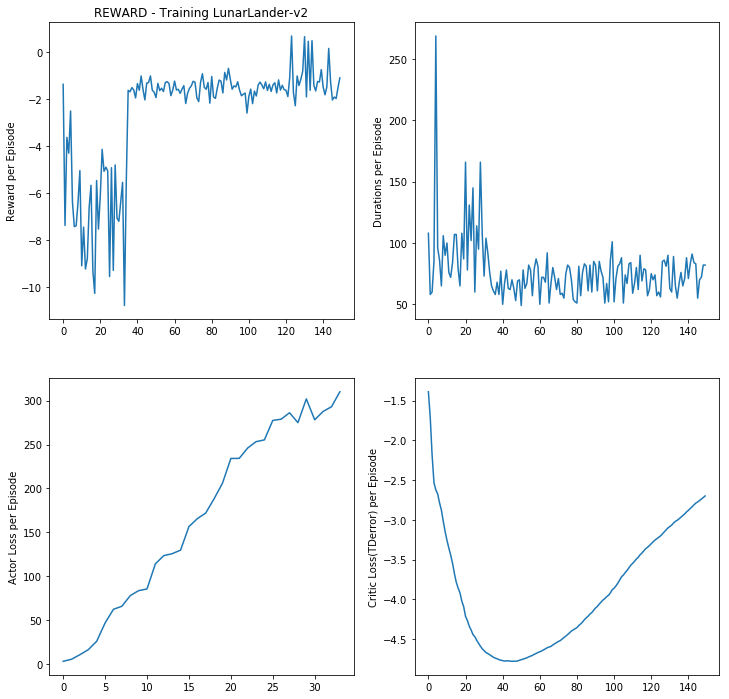

In [11]:
#r3, d3, l_A3, l_C3 = start_r('LunarLander-v2')
plot(r3, d3, l_A3, l_C3)
print "configA: "
print configA
print "configC: "
print configC

In [12]:
print "episode, r > 0: %.01f%s" % (float(r_percent(r3, 0)*100), "%")
print "episode, r > -1: %.01f%s" % (float(r_percent (r3, -1)*100) , "%")
print "episode, r > -2: %.01f%s" % (float(r_percent (r3, -2)*100) , "%")
print "Highest score: %.02f" % max(r3)
print "Highest total score: %.01f" % max([x*y for x, y in zip(r3, d3)])

episode, r > 0: 3.3%
episode, r > -1: 6.7%
episode, r > -2: 72.0%
Highest score: 0.70
Highest total score: 42.2


### Inception - with balanced experience replay  (AC-REPLAY(balanced))

*I am ensuring 50%/50% samples of positive/negative rewards, which I called good/bad memory.
Learning from a balanced memory could generate a aignificant boost in DQN.*

In [54]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

def start_r(GAME_NAME, BATCH_SIZE=32):
    env = gym.make(GAME_NAME)
    actor = Actor(env.observation_space, env.action_space)
    critic = Critic(env.observation_space, env.action_space)
    
    reward_per_epi=[]
    durations_per_epi=[]
    l_A=[]
    l_C=[]
    
    MAX_EPISODE = 150
    RENDER = False
    MAX_EP_STEPS= 1000
    DISPLAY_REWARD_THRESHOLD=200
    BATCH_SIZE=BATCH_SIZE  # try 5
    MEMORY_CAPACITY=5000
    
    replay_memory = ReplayMemory(MEMORY_CAPACITY)
    
    print "begin.\n\n"
    for i_episode in range(MAX_EPISODE):
        s = env.reset()
        track_r = []    # 每回合的所有奖励
        critic._v_=[]
        actor._loss_=[]
        for t in count():
            if RENDER: env.render()

            a = actor.choose_action(s)

            s_, r, done, info = env.step(a)

            if done: r = -20    # 回合结束的惩罚/ Penalty if die

            track_r.append(r)
            
            if (t%2==0 and r  >0) or (t%2!=0 and r <= 0):
                replay_memory.save(s, a, r, s_)   # Save transition into memeory
            
            if len(replay_memory) > BATCH_SIZE:
                
                transitions = replay_memory.sample(BATCH_SIZE)
                batch = Transition(*zip(*transitions))
                
                s_b = np.asarray(batch.state)       
                s_b_n = np.asarray(batch.next_state)  
                a_b = np.asarray(batch.action).reshape(BATCH_SIZE, 1)
                r_b = np.asarray(batch.reward).reshape(BATCH_SIZE, 1) 
                
                td_error = critic.learn(s_b, r_b, s_b_n)  # Critic Learn 学习
                actor.learn(s_b, a_b, td_error)     # Actor Learn 学习

            s = s_
            
            print "... in episode (%d) step (%d)" % (i_episode+1,t)
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())
                
            #env.render()

            if done or t >= MAX_EP_STEPS:
                # 回合结束, 打印回合累积奖励

                ep_rs_sum = sum(track_r)/float(t)
                if 'running_reward' not in globals():
                    running_reward = ep_rs_sum
                else:
                    running_reward = running_reward * 0.95 + ep_rs_sum * 0.05
                if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True  # rendering
                reward_per_epi.append(running_reward)
                durations_per_epi.append(t)
                l_A.append(np.mean(actor._loss_))
                l_C.append(np.mean(critic._loss_))
                print("episode:", i_episode, "  reward:", running_reward)
                plot(reward_per_epi, durations_per_epi, l_A, l_C)

                break
            
    return reward_per_epi, durations_per_epi, l_A, l_C       

    

configA: 
{'learning_rate': 0.00025, 'outputs_dim': 4, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}
configC: 
{'learning_rate': 0.00025, 'outputs_dim': 1, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}


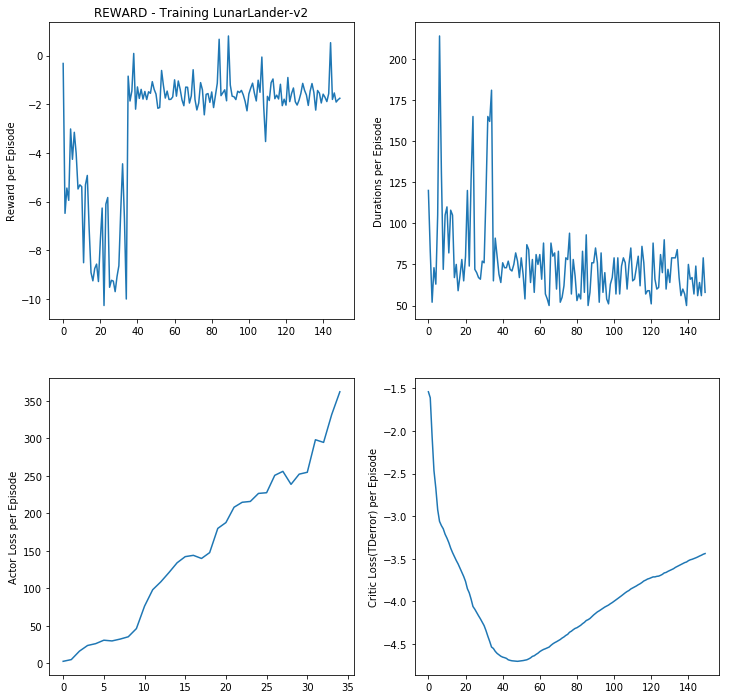

In [18]:
#from MemoryBuffer import ReplayMemory
#r2, d2, l_A2, l_C2 = start_r('LunarLander-v2')
print "configA: "
print configA
print "configC: "
print configC
plot(r2, d2, l_A2, l_C2)

In [32]:
print "episode, r > 0: %.01f%s" % (float(r_percent(r2, 0)*100), "%")
print "episode, r > -1: %.01f%s" % (float(r_percent (r2, -1)*100) , "%")
print "episode, r > -2: %.01f%s" % (float(r_percent (r2, -2)*100) , "%")
print "Highest score: %.02f" % max(r2)
print "Highest total score: %.01f" % max([x*y for x, y in zip(r2, d2)])

episode, r > 0: 2.7%
episode, r > -1: 8.0%
episode, r > -2: 67.3%
Highest score: 0.81
Highest total score: 61.8


#### Batch size of 4. 

### r4, d4, l_A4, l_C4 = start_r('LunarLander-v2', BATCH_SIZE=8)
print "configA: "
print configA
print "configC: "
print configC
plot(r2, d2, l_A2, l_C2)

#### Batch size of 2 and 1.  

configA: 
{'learning_rate': 0.00025, 'outputs_dim': 4, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}
configC: 
{'learning_rate': 0.00025, 'outputs_dim': 1, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}


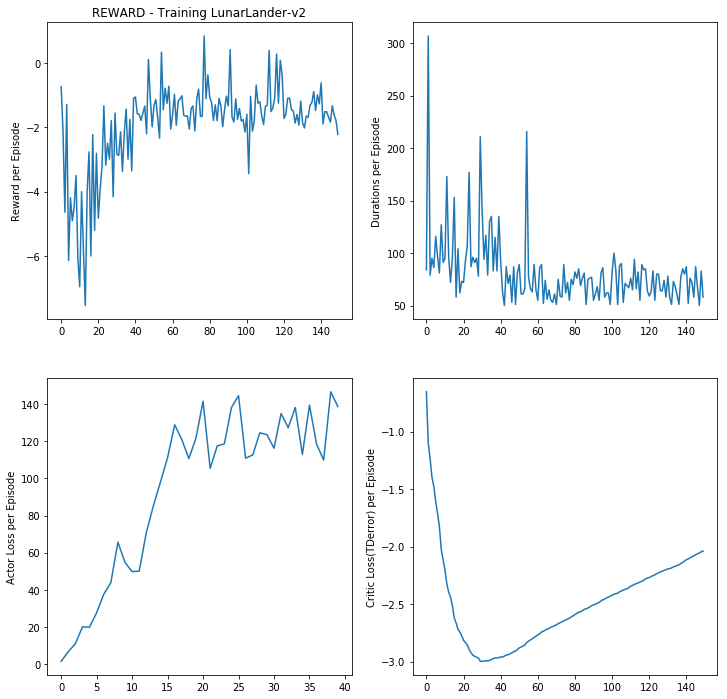

In [53]:
#vr3, d3, l_A3, l_C3 = start_r('LunarLander-v2', BATCH_SIZE=2)
print "configA: "
print configA
print "configC: "
print configC
plot(r2, d2, l_A2, l_C2)

In [16]:
print "episode, r > 0: %.01f%s" % (float(r_percent(r2, 0)*100), "%")
print "episode, r > -1: %.01f%s" % (float(r_percent (r2, -1)*100) , "%")
print "episode, r > -2: %.01f%s" % (float(r_percent (r2, -2)*100) , "%")
print "Highest score: %.02f" % max(r2)
print "Highest total score: %.01f" % max([x*y for x, y in zip(r2, d2)])

episode, r > 0: 4.7%
episode, r > -1: 12.0%
episode, r > -2: 72.0%
Highest score: 0.83
Highest total score: 71.6


configA: 
{'learning_rate': 0.00025, 'outputs_dim': 4, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}
configC: 
{'learning_rate': 0.00025, 'outputs_dim': 1, 'inputs_dim': 8, 'betas': (0.001, 0.9), 'hidden_dim': 50, 'weight_decay': 0.0001, 'GAMMA': 0.99}


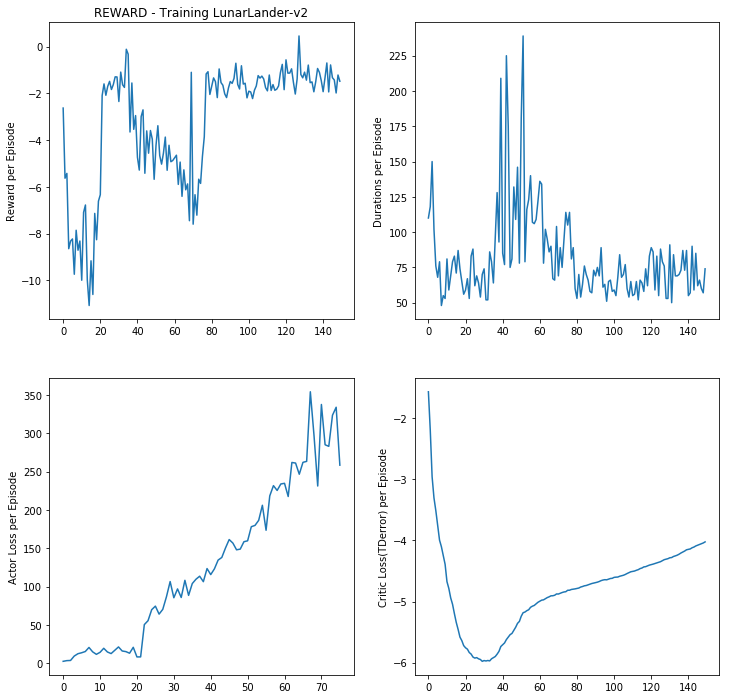

In [21]:
#r3, d3, l_A3, l_C3 = start_r('LunarLander-v2', BATCH_SIZE=1)
print "configA: "
print configA
print "configC: "
print configC
plot(r3, d3, l_A3, l_C3)

In [51]:
print "episode, r > 0: %.01f%s" % (float(r_percent(r3, 0)*100), "%")
print "episode, r > -1: %.01f%s" % (float(r_percent (r3, -1)*100) , "%")
print "episode, r > -2: %.01f%s" % (float(r_percent (r3, -2)*100) , "%")
print "Highest score: %.02f" % max(r2)
print "Highest total score: %.01f" % max([x*y for x, y in zip(r3, d3)])

episode, r > 0: 0.7%
episode, r > -1: 8.7%
episode, r > -2: 53.3%
Highest score: 0.83
Highest total score: 27.4


### Inception - (A3C) Asynthronous Advantage Actor-Critic


In [8]:
in progress

NameError: name 'r' is not defined